# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). 
To begin with the correct libraries are downloaded and the spark session is started.

In [5]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, \
    IDF, StringIndexer
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when, col
import re
from pyspark.sql.functions import count
from pyspark.sql import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import lag, row_number

import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier

In [6]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Capstone Project") \
    .getOrCreate()

# Load the Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. This is then loaded to the local computer to allow the use of Spark to analyse.

In [7]:
stack_overflow_data = 'mini_sparkify_event_data.json'

In [8]:
df = spark.read.json(stack_overflow_data)

# Exploratory Data Analysis

In [9]:
df.head() #see variable used within the data


Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [10]:
df.count() # see numer of interactions

286500

In [11]:
df_no_users= df.select('userId').dropDuplicates().count() # see the number of users in dataset
df_no_users

226

# Define Churn
There is currently no column to signify when a customer has churned - we need to create this whilst also creating a list of all the users who churn.

In [12]:
cancel= ['Cancellation Confirmation']#recording the page which signifys churn
df= df.withColumn('churn', when(col('page').isin(cancel),1).otherwise(0))# creating a column which is 1 when churn occurs, 0 when not. 

cancel_df= df.where(df.churn == 1) # df of all churn events
cancel_users = cancel_df.select('userId').rdd.flatMap(lambda x: x).collect() #collect the userids of those who churn
df = df.withColumn('will_cancel', F.when(df['userId'].isin(cancel_users), 1).otherwise(0))#create a column in the original dataset which is 1 if the customer will churn and 0 without.


We want to know if customers who will ultimately churn are significantly different than those who do so - in order to do this we will create two databases one with all the inteactions of the customers who will churn and one with all other customer interactions. 

In [13]:

non_cancel_df_big = df.where(~col('userId').isin(cancel_users))
cancel_df_big = df.where(col('userId').isin(cancel_users))

Now we want to find the number of users in each

In [14]:
cancel_df_user= cancel_df_big.dropDuplicates(['userId'])

cancel_df_user.count()


52

In [15]:
non_cancel_df_user= non_cancel_df_big.dropDuplicates(['userId'])
non_cancel_df_user.count()

174

Now for the same with interactions and the ratio of the two groups.

In [16]:
cancel_df_big.count()


44864

In [17]:
non_cancel_df_big.count()

241636

In [18]:
non_cancel_df_big.count()/cancel_df_big.count() # work out the proportion of the two groups


5.385966476462197

We want the number of customers in each level of subscription

In [19]:
cancel_df_user.groupby(cancel_df_user.level).agg(count('*').alias('no_customers')).collect()

[Row(level='free', no_customers=44), Row(level='paid', no_customers=8)]

In [20]:
non_cancel_df_user.groupby(non_cancel_df_user.level).agg(count('*').alias('no_customers')).collect()

[Row(level='free', no_customers=134), Row(level='paid', no_customers=40)]

Now plot this

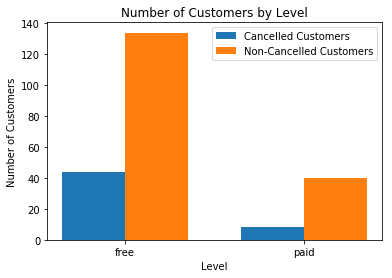

In [21]:

import numpy as np
# Data
levels = ['free', 'paid']
no_customers_cancel = [44, 8]
no_customers_non_cancel = [134, 40]
bar_width= 0.35
r1 = np.arange(len(levels))
r2 = [x + bar_width for x in r1]

# Plotting
plt.bar(r1, no_customers_cancel, width= bar_width, label='Cancelled Customers')
plt.bar(r2,  no_customers_non_cancel,width= bar_width , label='Non-Cancelled Customers')
plt.xlabel('Level')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Level')
plt.xticks([r + bar_width/2 for r in range(len(levels))], levels)

plt.legend()
plt.show()

We can also compare the average number of songs both customers who churn and those who don't listen to

In [59]:
cancel_df_song= cancel_df_big.select('song').count() # count the number of songs in churned customer df
cancel_df_user= cancel_df_big.select('userId').dropDuplicates().count() # count number of users
avg_song= cancel_df_song / cancel_df_user # find average number of songs
avg_song

862.7692307692307

In [60]:
non_cancel_df_song= non_cancel_df_big.select('song').count() # now do same for customers who dont churn 
non_cancel_df_user= non_cancel_df_big.select('userId').dropDuplicates().count()
avg_song2= non_cancel_df_song / non_cancel_df_user
avg_song2

1388.712643678161

We will create a window for the last 20 actions which a users does before they cancel their account and see if there is any pattern when comapred to all ac tions within the dataset. 

In [62]:
window_range = Window.partitionBy("userId").orderBy(col('ts').desc())# group by user and order their values by time



In [63]:
c_df_with_row_number = cancel_df_big.withColumn("row_number", row_number().over(window_range)) # number rows of each partition

In [64]:
last_twenty = c_df_with_row_number.filter(col("row_number") <= 20) #subset data to last 20 actions each customer takes

In [65]:
last_twenty.count()

1031

In [66]:
last_twenty_page = last_twenty.groupby(last_twenty.page).count().collect() #show the  occurances of each page in the last twenty actions databsase
last_twenty_page

[Row(page='Cancel', count=52),
 Row(page='Thumbs Down', count=18),
 Row(page='Home', count=36),
 Row(page='Downgrade', count=27),
 Row(page='Roll Advert', count=37),
 Row(page='Logout', count=13),
 Row(page='Save Settings', count=1),
 Row(page='Cancellation Confirmation', count=52),
 Row(page='Settings', count=24),
 Row(page='Add to Playlist', count=19),
 Row(page='Add Friend', count=11),
 Row(page='NextSong', count=696),
 Row(page='Thumbs Up', count=38),
 Row(page='Help', count=4),
 Row(page='Upgrade', count=1),
 Row(page='Error', count=2)]

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   52|
|         Thumbs Down|   18|
|                Home|   36|
|           Downgrade|   27|
|         Roll Advert|   37|
|              Logout|   13|
|       Save Settings|    1|
|Cancellation Conf...|   52|
|            Settings|   24|
|     Add to Playlist|   19|
|          Add Friend|   11|
|            NextSong|  696|
|           Thumbs Up|   38|
|                Help|    4|
|             Upgrade|    1|
|               Error|    2|
+--------------------+-----+



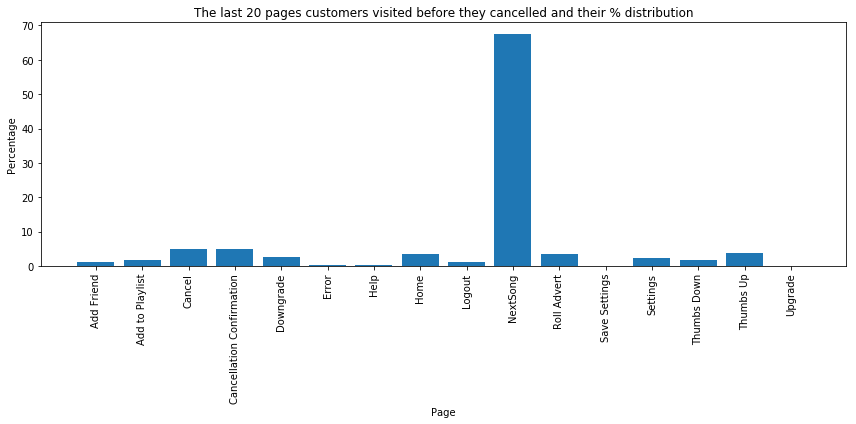

In [67]:
last_twenty_df= spark.createDataFrame(last_twenty_page, ['page', 'count']) #make a dataframe for this
last_twenty_df.show()
total_count = last_twenty_df.select(F.sum('count')).collect()[0][0] # calculate a total sum of the count column to work it out as a percentage distribution
last_twenty_df= last_twenty_df.withColumn('percentage', (last_twenty_df['count'] / total_count) * 100)#add % column to database
#convert  to pandas and plot
last_twenty_pd= last_twenty_df.toPandas()
last_twenty_pd =last_twenty_pd.sort_values(by='percentage', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(last_twenty_pd['page'], last_twenty_pd['percentage'])
plt.xticks(rotation=90)
plt.xlabel('Page')
plt.ylabel('Percentage')
plt.title('The last 20 pages customers visited before they cancelled and their % distribution')
plt.tight_layout()


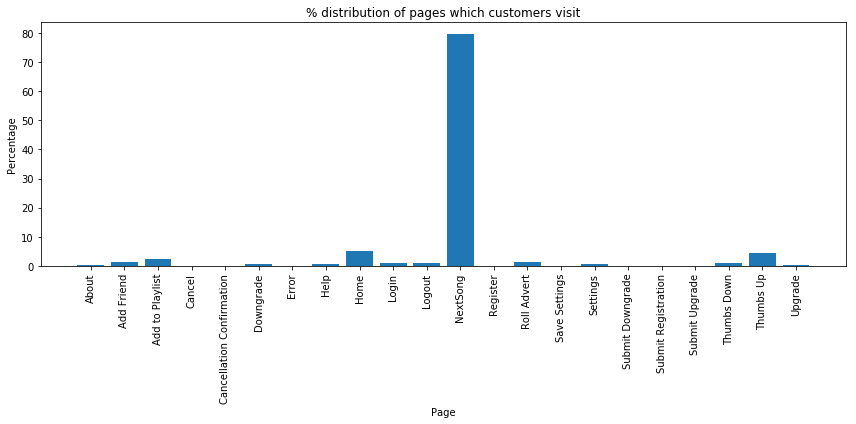

In [68]:
#now do same for full dataset
df_page= df.groupby(df.page).count().collect()
df_pd= spark.createDataFrame(df_page, ['page', 'count'])
total_count = df_pd.select(F.sum('count')).collect()[0][0]
df_pd= df_pd.withColumn('percentage', (df_pd['count'] / total_count) * 100)
df_pd= df_pd.toPandas()

df_pd =df_pd.sort_values(by='percentage', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(df_pd['page'], df_pd['percentage'])
plt.xticks(rotation=90)
plt.xlabel('Page')
plt.ylabel('Percentage')
plt.title('% distribution of pages which customers visit')
plt.tight_layout()

# Feature Engineering
Now we have to ensure all of the predictor variables are in the correct format to be used by the modelling techniques in the next section - that is they are all numeric and then inputted as a vector. The variables we are using are gender, level, sessionid, iteminsession and page. Also create an identifier colum for customers who will churn which is what will be predicted

In [69]:
df = spark.read.json(stack_overflow_data)
df = df.withColumn('gender_numeric', when(df.gender == 'm', 1).otherwise(0)) # change gender to numeric binary 
df = df.withColumn('level_numeric', when(df.level == 'paid', 1).otherwise(0)) # change subscription to numeric binary
df = df.withColumn('will_cancel', F.when(df['userId'].isin(cancel_users), 1).otherwise(0)) # create target variable
df= df.withColumn('churn', when(col('page').isin(cancel),1).otherwise(0))

Page is now the only non-numeric vector and will have to be converted using below functions

In [23]:




regexTokenizer = RegexTokenizer(inputCol="page", outputCol='pagewords', pattern="\\W")

df = regexTokenizer.transform(df)

df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, will_cancel=0, pagewords=['nextsong'])

In [24]:

cv = CountVectorizer(inputCol="pagewords", outputCol="TF", vocabSize=1000)
cvmodel = cv.fit(df)
df = cvmodel.transform(df)



In [25]:
idf = IDF(inputCol="TF", outputCol="TFIDF")

idfModel = idf.fit(df)

df = idfModel.transform(df)

df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, will_cancel=0, pagewords=['nextsong'], TF=SparseVector(26, {0: 1.0}), TFIDF=SparseVector(26, {0: 0.2279}))

Now we have converted page to the numeric TFIDF column we create a vector of all of the numeric predictors we have identified

In [73]:
assembler = VectorAssembler(inputCols=['TFIDF','gender_numeric', 'level_numeric','sessionId', 'itemInSession'], outputCol='features')
df = assembler.transform(df)

# Modeling
Split the full dataset into train, test, and validation sets.

In [74]:
train_ratio = 0.7
test_ratio = 0.2
validation_ratio = 0.1

# Split the dataset
train_data, test_data, validation_data = df.randomSplit([train_ratio, test_ratio, validation_ratio], seed=42)
train_data.show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------------+-------------+-----------+-----+--------------------+--------------------+--------------------+--------------------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|gender_numeric|level_numeric|will_cancel|churn|           pagewords|                  TF|               TFIDF|            features|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------------+-------------+-----------+-----+--------------------+--------------------+--------------------+--------------------+
|  null

The first model to be used will be logistic regression which we will fit to the training set and make predictions for the test set.

In [34]:
lr = LogisticRegression(featuresCol='features', labelCol='will_cancel')
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)


+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------------+-------------+-----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|gender_numeric|level_numeric|will_cancel|churn|           pagewords|                  TF|               TFIDF|            features|       rawPrediction|         probability|prediction|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------------+-------------+----

We can then generate metrics for the model - in this case F score

In [35]:

evaluator = MulticlassClassificationEvaluator(labelCol='will_cancel', predictionCol='prediction', metricName='f1')
f1_score = evaluator.evaluate(predictions)

In [36]:
print("F1 Score on the test set:", f1_score)

F1 Score on the test set: 0.7759261452270115


We are now going the same for decision tree- making the model, applying to the test set and then evaluate the f score. We are going to do it three times with three different levels of the MaxDepth hyperparameter to choose the ones that supplies the greatest f score.

In [78]:
dt = DecisionTreeClassifier(labelCol="will_cancel", featuresCol="features", maxDepth = 10)
dt2 = DecisionTreeClassifier(labelCol="will_cancel", featuresCol="features", maxDepth = 20)
dt3 = DecisionTreeClassifier(labelCol="will_cancel", featuresCol="features", maxDepth = 30)
model= dt.fit(train_data)
model2 = dt2.fit(train_data)
model3 = dt3.fit(train_data)
predictions1 = model.transform(test_data)
predictions2 = model2.transform(test_data)
predictions3 = model3.transform(test_data)


evaluator2 = MulticlassClassificationEvaluator(labelCol='will_cancel', predictionCol='prediction', metricName='f1')


f1_score = evaluator2.evaluate(predictions)
f1_score2 = evaluator2.evaluate(predictions2)
f1_score3 = evaluator2.evaluate(predictions3)
print("F1 Score on the test set:", f1_score)
print("F1 Score on the test set:", f1_score2)
print("F1 Score on the test set:", f1_score3)

F1 Score on the test set: 0.7751195124974326
F1 Score on the test set: 0.8086236661380297
F1 Score on the test set: 0.8067068379012473


And now the same with the random forest classifier with three different numbers of trees featured.

In [91]:
rf = RandomForestClassifier(labelCol="will_cancel", featuresCol="features", numTrees=10)
rf2 = RandomForestClassifier(labelCol="will_cancel", featuresCol="features", numTrees=50)
rf3 = RandomForestClassifier(labelCol="will_cancel", featuresCol="features", numTrees=100)
model = rf.fit(train_data)
model2 = rf2.fit(train_data)
model3 = rf3.fit(train_data)
predictions = model.transform(test_data)
predictions2 = model2.transform(test_data)
predictions3 = model3.transform(test_data)
evaluator3 = MulticlassClassificationEvaluator(labelCol='will_cancel', predictionCol='prediction', metricName='f1')
f1_score = evaluator3.evaluate(predictions)
f1_score2 = evaluator3.evaluate(predictions2)
f1_score3 = evaluator3.evaluate(predictions3)
print("F1 Score on the test set:", f1_score)
print("F1 Score on the test set:", f1_score2)
print("F1 Score on the test set:", f1_score3)

F1 Score on the test set: 0.7751195124974326
F1 Score on the test set: 0.7751195124974326
F1 Score on the test set: 0.7751195124974326


And finally gradient boosted trees (GBTs) are our final model and again we will compare with different levels of hyperparameter MaxDepth

In [95]:
gbt = GBTClassifier(labelCol="will_cancel", featuresCol="features", maxDepth=10)
gbt2 = GBTClassifier(labelCol="will_cancel", featuresCol="features", maxDepth=20)
gbt3 = GBTClassifier(labelCol="will_cancel", featuresCol="features", maxDepth=30)
model = gbt.fit(train_data)
model2 = gbt2.fit(train_data)
model3 = gbt3.fit(train_data)
predictions = model.transform(test_data)
predictions2 = model2.transform(test_data)
predictions3 = model3.transform(test_data)
evaluator4 = MulticlassClassificationEvaluator(labelCol='will_cancel', predictionCol='prediction', metricName='f1')
f1_score = evaluator4.evaluate(predictions)
f1_score2 = evaluator4.evaluate(predictions2)
f1_score3 = evaluator4.evaluate(predictions3)
print("F1 Score on the test set:", f1_score)
print("F1 Score on the test set:", f1_score2)
print("F1 Score on the test set:", f1_score3)

F1 Score on the test set: 0.8068261010276427
F1 Score on the test set: 0.8150341296503657
F1 Score on the test set: 0.8139057695393279


GBT provided the greatest f score so we will move on and apply it to the validation set to get final results of our chosen metrics. First is the f score metric.

In [78]:
gbt2 = GBTClassifier(labelCol="will_cancel", featuresCol="features", maxDepth=20)
model2 = gbt2.fit(train_data)
predictions2 = model2.transform(validation_data)
evaluator4 = MulticlassClassificationEvaluator(labelCol='will_cancel', predictionCol='prediction', metricName='f1')
f1_score2 = evaluator4.evaluate(predictions2)
print("F1 Score on the test set:", f1_score2)

F1 Score on the test set: 0.8161844877228861


And the same for accuracy

In [81]:
evaluator5 = MulticlassClassificationEvaluator(labelCol='will_cancel', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator5.evaluate(predictions2)
print("Accuracy:", accuracy)

Accuracy: 0.8528399915748087


And finally we will plot the f scores produced by all four of the methods to include in the report

In [ ]:


# Define the methods and their corresponding F-scores
methods = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'GBT']
f_scores = [0.775926, 0.80863, 0.775195, 0.81503]

# Plot the F-scores
plt.bar(methods, f_scores)
plt.xlabel('Methods')
plt.ylabel('F-Score')
plt.xticks(rotation='vertical')
plt.ylim(0.7, 0.85)
plt.title('Comparison of F-Scores for Different Methods')
plt.show()